# Predicting Car Prices Using K-nearest Neighbors

In this project, I will use the K-nearest neighbors model to predict a car's market price using its attributes. The data set I will be working with contains information on various cars. For each car I have information about the technical aspects of the vehicle such as the motor's displacement, the weight of the car, the miles per gallon, how fast the car accelerates, and more. The data set can be downloaded [here](https://archive.ics.uci.edu/ml/datasets/automobile)

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,cross_val_score,KFold
%matplotlib inline

In [2]:
# Name columns 
cols = ['symboling', 'normalized-losses', 'make', 'fuel-type', 'aspiration', 'num-of-doors', 'body-style', 
        'drive-wheels', 'engine-location', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-type', 
        'num-of-cylinders', 'engine-size', 'fuel-system', 'bore', 'stroke', 'compression-rate', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']
cars=pd.read_csv('imports-85.data',names=cols)

In [3]:
# Explore the data
print(cars.head())
print('\n')
print(cars.info())

   symboling normalized-losses         make fuel-type aspiration num-of-doors  \
0          3                 ?  alfa-romero       gas        std          two   
1          3                 ?  alfa-romero       gas        std          two   
2          1                 ?  alfa-romero       gas        std          two   
3          2               164         audi       gas        std         four   
4          2               164         audi       gas        std         four   

    body-style drive-wheels engine-location  wheel-base  ...  engine-size  \
0  convertible          rwd           front        88.6  ...          130   
1  convertible          rwd           front        88.6  ...          130   
2    hatchback          rwd           front        94.5  ...          152   
3        sedan          fwd           front        99.8  ...          109   
4        sedan          4wd           front        99.4  ...          136   

   fuel-system  bore  stroke compression-rate hors

## Data Cleaning

In [4]:
# Clean missing data
cars.replace('?',np.nan,inplace=True)

In [5]:
# Prepare numerical columns
numerical_cols=['normalized-losses', 'wheel-base', 'length',
                'width', 'height', 'curb-weight','engine-size', 'bore', 
                'stroke', 'compression-rate','horsepower', 
                'peak-rpm', 'city-mpg', 'highway-mpg', 'price']

# Set these columns in float type
cars_numerical=cars[numerical_cols].astype(float)

In [6]:
# Remove rows with missing price 
cars_numerical.dropna(subset=['price'],inplace=True)

# Replace missing values using the average values of that column
cars_numerical.fillna(cars_numerical.mean(),inplace=True)

## Univariate Model

In [7]:
# A function that returns the root mean square error using a single feature
def knn_train_test(train_col,target_col):
    scaler=MinMaxScaler()
    X=cars_numerical[[train_col]]
    y=cars_numerical[target_col]
    
    # Split the data into two halfs: train/test sets
    X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.5, random_state=1)
    
    # Data Transformation
    X_train=scaler.fit_transform(X_train)
    X_test=scaler.transform(X_test)
    
    # Apply K-neighbor regression
    knn=KNeighborsRegressor()
    knn.fit(X_train,y_train)
    predictions=knn.predict(X_test)
    rmse=mean_squared_error(y_test,predictions)**(1/2)
    return rmse

feature_cols=cars_numerical.columns.drop('price')
one_fea_rmses={}

# Calculate root mean square error for each feature
for col in feature_cols:
    one_fea_rmses[col]=knn_train_test(col,'price')
one_fea_rmses=pd.Series(one_fea_rmses)
one_fea_rmses

normalized-losses    7788.447578
wheel-base           5822.650427
length               5718.305420
width                4565.264501
height               7800.857350
curb-weight          3827.048279
engine-size          3494.950928
bore                 6666.333504
stroke               7231.993469
compression-rate     6029.246713
horsepower           3846.244242
peak-rpm             7791.385547
city-mpg             4117.090197
highway-mpg          3988.308776
dtype: float64

In [8]:
# Calculate RMSEs using different k values
def knn_train_test_k(train_col,target_col):
    scaler=MinMaxScaler()
    X=cars_numerical[[train_col]]
    y=cars_numerical[target_col]
    
    # Splitting and transforming data
    X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.5, random_state=1)
    X_train=scaler.fit_transform(X_train)
    X_test=scaler.transform(X_test)
    
    k_values=[1,3,5,7,9]
    k_rmses={}
    for k in k_values:
        
        # Fit model using k-nearest neighbors
        knn=KNeighborsRegressor(n_neighbors=k)
        knn.fit(X_train,y_train)
        predictions=knn.predict(X_test)
        rmse=mean_squared_error(y_test,predictions)**(1/2)
        k_rmses[k]=rmse
    return k_rmses

k_one_fea_rmses={}
for col in feature_cols:
    k_one_fea_rmses[col]=knn_train_test_k(col,'price')
k_one_fea_rmses=pd.DataFrame(k_one_fea_rmses)
k_one_fea_rmses

,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg,highway-mpg
1,11308.689545,6511.074890,5194.617909,5072.338292,9599.465975,5684.673773,3387.746430,8040.020588,8081.559472,9749.369726,4438.906043,8569.726056,4783.481251,6436.121344
3,9057.257082,5981.456741,5259.762486,4323.309432,8201.011849,4076.217604,3436.887782,6255.091196,6661.108116,6518.721301,4078.807094,7052.103852,4074.102613,4392.925635
5,7788.447578,5822.650427,5718.305420,4565.264501,7800.857350,3827.048279,3494.950928,6666.333504,7231.993469,6029.246713,3846.244242,7791.385547,4117.090197,3988.308776
7,7537.909730,6066.586550,5664.385427,4633.677505,7768.700803,3746.454922,3786.098020,6720.241439,7451.020256,5873.390199,4042.553921,8157.251384,4354.659091,3934.102114
9,7529.866921,6172.425944,5702.031461,4779.887777,7866.868619,3868.716851,3904.067044,7023.149418,7266.786659,6147.252608,4227.808471,8053.499658,4378.458172,4130.879553


Text(0, 0.5, 'RMSE')

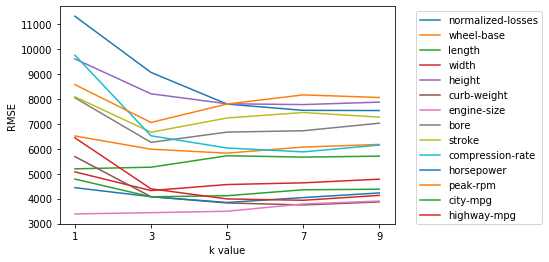

In [9]:
# Plot RMSE of each feature using different k values
k_one_fea_rmses.plot()
plt.xticks([1,3,5,7,9])
plt.legend(bbox_to_anchor=(1.05, 1),loc='upper left')
plt.xlabel('k value')
plt.ylabel('RMSE')

# Engine-size is the best feature to predict price

## Multivariate Model

In [10]:
# A function that returns RMSEs using multiple best features
def knn_train_test_multi(train_cols,target_col):
    scaler=MinMaxScaler()
    X=cars_numerical[train_cols]
    y=cars_numerical[target_col]
    
    # Splitting and transforming data
    X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.5, random_state=1)
    X_train=scaler.fit_transform(X_train)
    X_test=scaler.transform(X_test)
    
    knn=KNeighborsRegressor()
    knn.fit(X_train,y_train)
    predictions=knn.predict(X_test)
    rmse=mean_squared_error(y_test,predictions)**(1/2)
    return rmse

# Sort best features in ascending order
best_features=one_fea_rmses.sort_values()
multi_fea_rmses={}
for n_fea in range(2,6):
    
    # Return results for best 2, 3, 4, 5 features
    train_cols=best_features.index[:n_fea]
    multi_fea_rmses['{} best features'.format(n_fea)]=knn_train_test_multi(train_cols,'price')
multi_fea_rmses
# Four best feature generate smallest RMSE

{'2 best features': 3479.827142685437,
 '3 best features': 3673.9191844488605,
 '4 best features': 3660.5886157099576,
 '5 best features': 3892.7037769968506}

# Hyperparameter Tuning

In [11]:
# A function that returns RMSEs using different k values
def knn_train_test_multi_k(train_cols,target_col):
    scaler=MinMaxScaler()
    X=cars_numerical[train_cols]
    y=cars_numerical[target_col]
    
    # Splitting and transforming data
    X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.5, random_state=1)
    X_train=scaler.fit_transform(X_train)
    X_test=scaler.transform(X_test)
    
    k_values=range(1,26)
    k_rmses={}
    for k in k_values:
        
        # Fit the model with k-nearest neighbors
        knn=KNeighborsRegressor(n_neighbors=k)
        knn.fit(X_train,y_train)
        predictions=knn.predict(X_test)
        rmse=mean_squared_error(y_test,predictions)**(1/2)
        k_rmses[k]=rmse
    return k_rmses

k_multi_fea_rmses={}
for n_fea in range(2,6):
    train_cols=best_features.index[:n_fea]
    k_multi_fea_rmses['{} best features'.format(n_fea)]=knn_train_test_multi_k(train_cols,'price')
k_multi_fea_rmses=pd.DataFrame(k_multi_fea_rmses)

Text(0, 0.5, 'RMSE')

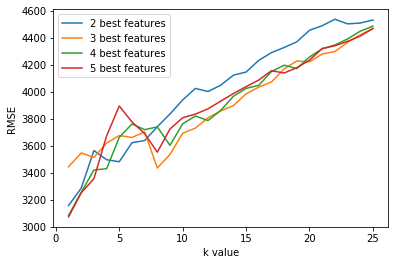

In [12]:
k_multi_fea_rmses.plot()
plt.xlabel('k value')
plt.ylabel('RMSE')


## K-fold Cross Validation 

In [13]:
# A function that returns RMSEs using multiple best features
def knn_cross_val(train_col,target_col):
    kf=KFold(n_splits=5, shuffle=True,random_state=1)
    knn=KNeighborsRegressor()
    scaler=MinMaxScaler()
    rmses=[]
    for train_index,test_index in kf.split(cars_numerical):
        X_train,X_test = cars_numerical[[train_col]].iloc[train_index], cars_numerical[[train_col]].iloc[test_index]
        y_train,y_test = cars_numerical[target_col].iloc[train_index], cars_numerical[target_col].iloc[test_index]
        
        # Data Transformation
        X_train=scaler.fit_transform(X_train)
        X_test=scaler.transform(X_test)
        knn.fit(X_train,y_train)
        predictions=knn.predict(X_test)
        rmse=mean_squared_error(y_test,predictions)**(1/2)
        rmses.append(rmse)
    avg_rmse = np.mean(rmses)
    return avg_rmse

cross_val_rmses={}
for col in feature_cols:
    cross_val_rmses[col]=knn_cross_val(col,'price')
cross_val_rmses=pd.Series(cross_val_rmses)
cross_val_rmses

normalized-losses    7050.933699
wheel-base           6047.957140
length               5612.232857
width                4195.234456
height               7581.158157
curb-weight          4317.168370
engine-size          3223.456962
bore                 6839.826481
stroke               7041.526615
compression-rate     6388.338562
horsepower           3768.187745
peak-rpm             7523.651558
city-mpg             4426.529241
highway-mpg          4142.295465
dtype: float64

In [18]:
# A function that returns RMSEs for different k-neighbors 
def knn_cross_val_k_fold(train_col,target_col):
    avg_rmses={}
    for k in range(1,26):
        kf=KFold(n_splits=5, shuffle=True,random_state=1)
        knn=KNeighborsRegressor(n_neighbors=k)
        scaler=MinMaxScaler()
        rmses=[]
        for train_index,test_index in kf.split(cars_numerical):
            X_train,X_test = cars_numerical[[train_col]].iloc[train_index], cars_numerical[[train_col]].iloc[test_index]
            y_train,y_test = cars_numerical[target_col].iloc[train_index], cars_numerical[target_col].iloc[test_index]
        
        # Data Transformation
            X_train=scaler.fit_transform(X_train)
            X_test=scaler.transform(X_test)
            knn.fit(X_train,y_train)
            predictions=knn.predict(X_test)
            rmse=mean_squared_error(y_test,predictions)**(1/2)
            rmses.append(rmse)
        avg_rmse = np.mean(rmses)
        avg_rmses[k]=avg_rmse
    return avg_rmses

k_fold_cross_val_rmses={}
for col in feature_cols:
    k_fold_cross_val_rmses[col]=knn_cross_val_k_fold(col,'price')
k_fold_cross_val_rmses=pd.DataFrame(k_fold_cross_val_rmses)

Text(0, 0.5, 'RMSE')

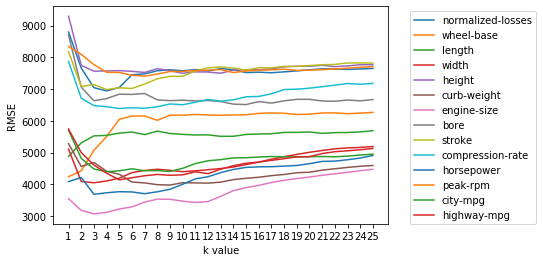

In [25]:
k_fold_cross_val_rmses.plot()
plt.xticks(range(1,26))
plt.legend(bbox_to_anchor=(1.05, 1),loc='upper left')
plt.xlabel('k value')
plt.ylabel('RMSE')

# Engine-size is proved to be the best feature to predict car price